# Import

In [1]:
#!jupyter nbconvert --to script model_build.ipynb

import csv
import json
#import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, linregress
from sklearn.preprocessing import StandardScaler
import random
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.python.client import device_lib
import matplotlib.colors as mcolors
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, matthews_corrcoef


2024-09-18 22:30:21.120396: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 22:30:21.139501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 22:30:21.163840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 22:30:21.163861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 22:30:21.179347: I tensorflow/core/platform/cpu_feature_gua

In [2]:
print(tf.__version__)

2.16.2


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2024-09-18 22:30:29.818306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 9566 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-09-18 22:30:29.819773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:1 with 9566 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-18 22:30:29.821016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:2 with 9566 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-09-18 22:30:29.822119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:3 with 9566 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5
2024-09-18 22:30:29.823241: I tensorflow/core/common_runtime/gpu

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10515224206676203915
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10031202304
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4520382244946479838
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10031202304
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14361637273488525220
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10031202304
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7592451124655572790
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5"
 x

In [4]:
MODEL_NAME = 'baseline_removed_medium'
RUN = 'run14_' + MODEL_NAME+ '/'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery_dissertation/data/
/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery_dissertation/output/run14_baseline_removed_medium/


In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load_data

In [6]:
# Initialize an empty list to store the arrays
X_dict = {}
Y_dict = {}

# Load each file and append the array to the list
for i in range(5):
    X_filename = f'X_fold{i}.npy'
    X_dict[i] = np.load(DATA_DIR + X_filename, allow_pickle=True)

    Y_filename = f'Y_fold{i}.npy'
    Y_dict[i] = np.load(DATA_DIR + Y_filename,  allow_pickle=True)

for i in range(5):
    print(f'i: {i}, X: {X_dict[i].shape}, Y: {Y_dict[i].shape}')


i: 0, X: (1113, 8), Y: (1113, 2)
i: 1, X: (1171, 8), Y: (1171, 2)
i: 2, X: (1258, 8), Y: (1258, 2)
i: 3, X: (1163, 8), Y: (1163, 2)
i: 4, X: (1080, 8), Y: (1080, 2)


In [7]:
for index in range(1):
    train_list = [0, 1, 2, 3, 4]
    train_list.remove(index)
    test_list = [index]

    print(f'train: {train_list}, test: {test_list}')

    X_train = X_dict[train_list[0]]
    Y_train = Y_dict[train_list[0]]
    X_test =  X_dict[test_list[0]]
    Y_test =  Y_dict[test_list[0]]
    
    for i_train in train_list[1:]:
        X_train = np.concatenate([X_train,X_dict[i_train] ],axis = 0)
        Y_train = np.concatenate([Y_train,Y_dict[i_train] ],axis = 0)

    for i_test in test_list[1:]:
        X_test = np.concatenate([X_test,X_dict[i_test] ],axis = 0)
        Y_test = np.concatenate([Y_test,Y_dict[i_test] ],axis = 0)

    print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}, X_test : {X_test.shape}, Y_test: {Y_test.shape}')

train: [1, 2, 3, 4], test: [0]
X_train: (4672, 8), Y_train: (4672, 2), X_test : (1113, 8), Y_test: (1113, 2)


In [8]:
X_train_demo          = np.array(X_train[:,0].tolist()).squeeze(1)
X_train_1_eye         = np.array(X_train[:,1].tolist())
X_train_1_eye_wavelet = np.array(X_train[:,2].tolist())
X_train_1_ecg         = np.array(X_train[:,3].tolist())
X_train_1_ecg_feature = np.array(X_train[:,4].tolist())
X_train_2_eye         = np.array(X_train[:,5].tolist())
X_train_2_ecg         = np.array(X_train[:,6].tolist())
X_train_2_ecg_feature = np.array(X_train[:,7].tolist())




In [9]:
#cliping with 99.5.5% 

X_train_1_eye = np.clip(X_train_1_eye, np.percentile(X_train_1_eye, 0.5), np.percentile(X_train_1_eye, 99.5))
X_train_1_eye_wavelet = np.clip(X_train_1_eye_wavelet, np.percentile(X_train_1_eye_wavelet, 0.5), np.percentile(X_train_1_eye_wavelet, 99.5))
X_train_1_ecg = np.clip(X_train_1_ecg, np.percentile(X_train_1_ecg, 0.5), np.percentile(X_train_1_ecg, 99.5))
X_train_1_ecg_feature = np.clip(X_train_1_ecg_feature, np.percentile(X_train_1_ecg_feature, 0.5), np.percentile(X_train_1_ecg_feature, 99.5))
X_train_2_eye = np.clip(X_train_2_eye, np.percentile(X_train_2_eye, 0.5), np.percentile(X_train_2_eye, 99.5))
#X_train_2_eye_wavelet = np.clip(X_train_2_eye_wavelet, np.percentile(X_train_2_eye_wavelet, 0.5), np.percentile(X_train_2_eye_wavelet, 99.5))
X_train_2_ecg = np.clip(X_train_2_ecg, np.percentile(X_train_2_ecg, 0.5), np.percentile(X_train_2_ecg, 99.5))
X_train_2_ecg_feature = np.clip(X_train_2_ecg_feature, np.percentile(X_train_2_ecg_feature, 0.5), np.percentile(X_train_2_ecg_feature, 99.5))

print(f'demo:          {X_train_demo.shape}\n\
eye_1:         {X_train_1_eye.shape}\neye_1_wavelet: {X_train_1_eye_wavelet.shape}\n\
ecg_1:         {X_train_1_ecg.shape}\necg_1_feature: {X_train_1_ecg_feature.shape}\n\
eye_2:         {X_train_2_eye.shape}\n\
ecg_2:         {X_train_2_ecg.shape}\necg_2_feature: {X_train_2_ecg_feature.shape}\n')

demo:          (4672, 17)
eye_1:         (4672, 60000, 5)
eye_1_wavelet: (4672, 60000, 5)
ecg_1:         (4672, 480, 6)
ecg_1_feature: (4672, 13)
eye_2:         (4672, 2500, 4)
ecg_2:         (4672, 20, 6)
ecg_2_feature: (4672, 13)



In [10]:
X_test_demo          = np.array(X_test[:,0].tolist()).squeeze(1)
X_test_1_eye         = np.array(X_test[:,1].tolist())
X_test_1_eye_wavelet = np.array(X_test[:,2].tolist())
X_test_1_ecg         = np.array(X_test[:,3].tolist())
X_test_1_ecg_feature = np.array(X_test[:,4].tolist())
X_test_2_eye         = np.array(X_test[:,5].tolist())
X_test_2_ecg         = np.array(X_test[:,6].tolist())
X_test_2_ecg_feature = np.array(X_test[:,7].tolist())




In [11]:
#cliping with 99.5% 

X_test_1_eye = np.clip(X_test_1_eye, np.percentile(X_test_1_eye, 0.5), np.percentile(X_test_1_eye, 99.5))
X_test_1_eye_wavelet = np.clip(X_test_1_eye_wavelet, np.percentile(X_test_1_eye_wavelet, 0.5), np.percentile(X_test_1_eye_wavelet, 99.5))
X_test_1_ecg = np.clip(X_test_1_ecg, np.percentile(X_test_1_ecg, 0.5), np.percentile(X_test_1_ecg, 99.5))
X_test_1_ecg_feature = np.clip(X_test_1_ecg_feature, np.percentile(X_test_1_ecg_feature, 0.5), np.percentile(X_test_1_ecg_feature, 99.5))
X_test_2_eye = np.clip(X_test_2_eye, np.percentile(X_test_2_eye, 0.5), np.percentile(X_test_2_eye, 99.5))
#X_test_2_eye_wavelet = np.clip(X_test_2_eye_wavelet, np.percentile(X_test_2_eye_wavelet, 0.5), np.percentile(X_test_2_eye_wavelet, 99.5))
X_test_2_ecg = np.clip(X_test_2_ecg, np.percentile(X_test_2_ecg, 0.5), np.percentile(X_test_2_ecg, 99.5))
X_test_2_ecg_feature = np.clip(X_test_2_ecg_feature, np.percentile(X_test_2_ecg_feature, 0.5), np.percentile(X_test_2_ecg_feature, 99.5))




print(f'demo:          {X_test_demo.shape}\n\
eye_1:         {X_test_1_eye.shape}\neye_1_wavelet: {X_test_1_eye_wavelet.shape}\n\
ecg_1:         {X_test_1_ecg.shape}\necg_1_feature: {X_test_1_ecg_feature.shape}\n\
eye_2:         {X_test_2_eye.shape}\n\
ecg_2:         {X_test_2_ecg.shape}\necg_2_feature: {X_test_2_ecg_feature.shape}\n')

demo:          (1113, 17)
eye_1:         (1113, 60000, 5)
eye_1_wavelet: (1113, 60000, 5)
ecg_1:         (1113, 480, 6)
ecg_1_feature: (1113, 13)
eye_2:         (1113, 2500, 4)
ecg_2:         (1113, 20, 6)
ecg_2_feature: (1113, 13)



In [12]:
Y_train_dif         = np.array(Y_train[:,0].tolist())
Y_train_acc         = np.array(Y_train[:,1].tolist())



print(f'Difficulty:       {Y_train_dif.shape}\nAccuracy:         {Y_train_acc.shape}')

Difficulty:       (4672,)
Accuracy:         (4672,)


In [13]:
Y_test_dif         = np.array(Y_test[:,0].tolist())
Y_test_acc         = np.array(Y_test[:,1].tolist())



print(f'Difficulty:       {Y_test_dif.shape}\nAccuracy:         {Y_test_acc.shape}')

Difficulty:       (1113,)
Accuracy:         (1113,)


In [14]:
EPOCHS = 200
BATCH_SIZE = 16
PATIENCE = 20

# Eye model

## Model Build

In [ ]:
def custom_CNN_layer(input_layer, start_neuron = 16, kernel_size=9, strides_size=1, max_pool_size=5, dropout=0.3, padding='valid'):
    cnn_layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    cnn_layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(cnn_layer)
    cnn_layer = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(cnn_layer)
    cnn_layer = tf.keras.layers.BatchNormalization()(cnn_layer)
    cnn_layer = tf.keras.layers.Dropout(dropout)(cnn_layer)
    return cnn_layer

In [ ]:
# #create model
# def baseline_CNN(shape, start_neuron = 16, kernel_size=9, strides_size=1, max_pool_size=5, dropout=0.3, padding='valid'):    

#     input_layer_demo     = tf.keras.Input((shape[1],), name='input_demo') 
#     input_layer_baseline = tf.keras.Input((shape[3], shape[4]), name='input_baseline') 
#     input_layer_samples  = tf.keras.Input((shape[6], shape[7]), name='input_sample') 

#     #baseline

#     conv_baseline = custom_CNN_layer(input_layer_baseline, start_neuron, kernel_size = 3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
#     conv_baseline = custom_CNN_layer(conv_baseline, start_neuron, kernel_size = 3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
#     conv_baseline = custom_CNN_layer(conv_baseline, start_neuron, kernel_size = 3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
#     conv_baseline = custom_CNN_layer(conv_baseline, start_neuron, kernel_size = 3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
#     conv_baseline = custom_CNN_layer(conv_baseline, start_neuron, kernel_size = 3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')

#     conv_baseline = custom_CNN_layer(conv_baseline, start_neuron * 2, kernel_size = 5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
#     conv_baseline = custom_CNN_layer(conv_baseline, start_neuron * 2, kernel_size = 5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
#     conv_baseline = custom_CNN_layer(conv_baseline, start_neuron * 2, kernel_size = 5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
#     conv_baseline = custom_CNN_layer(conv_baseline, start_neuron * 2, kernel_size = 5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
#     conv_baseline = custom_CNN_layer(conv_baseline, start_neuron * 4, kernel_size = 5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
#     conv_baseline = tf.keras.layers.Flatten()(conv_baseline)
#     # lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(conv_2)
#     # lstm_1 = tf.keras.layers.Dropout(dropout)(lstm_1)

#     # lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(lstm_1)
#     # lstm_2 = tf.keras.layers.Dropout(dropout)(lstm_2)
#     # lstm_2 = tf.keras.layers.Flatten()(lstm_2)

#     #samples
#     conv_sample  = custom_CNN_layer(input_layer_samples, start_neuron, kernel_size = 3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
#     conv_sample  = custom_CNN_layer(conv_sample, start_neuron , kernel_size =  3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
#     conv_sample  = custom_CNN_layer(conv_sample, start_neuron , kernel_size =  3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')

#     conv_sample  = custom_CNN_layer(conv_sample, start_neuron * 2, kernel_size = 5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
#     conv_sample  = custom_CNN_layer(conv_sample, start_neuron * 2, kernel_size = 5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
#     conv_sample  = custom_CNN_layer(conv_sample, start_neuron * 4, kernel_size = 5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
#     conv_sample = tf.keras.layers.Flatten()(conv_sample)
    
#     concat_layer = tf.keras.layers.Concatenate()([conv_baseline, conv_sample, input_layer_demo])
    
#     output_layer = tf.keras.layers.Dense(start_neuron*8,activation=tf.keras.layers.LeakyReLU())(concat_layer)
#     output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
#     output_layer = tf.keras.layers.Dense(start_neuron*8,activation=tf.keras.layers.LeakyReLU())(output_layer)
#     output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    
#     output_0 = tf.keras.layers.Dense(3, activation='softmax', name='difficulty')(output_layer)


#     model = tf.keras.Model(inputs=[input_layer_demo, input_layer_baseline, input_layer_samples], outputs=[output_0])
#     #loss_weights = [scaling_factors[0]*5,scaling_factors[1],scaling_factors[2],scaling_factors[3],scaling_factors[4]]   
    
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     #model.compile(optimizer = 'adam',loss = ['mae','mae','mae','mae','mae'],loss_weights=loss_weights)
#     return model

In [ ]:
#create model
def baseline_CNN(shape, start_neuron = 16, kernel_size=9, strides_size=1, max_pool_size=5, dropout=0.3, padding='valid'):    

    input_layer_demo     = tf.keras.Input((shape[1],), name='input_demo') 
    input_layer_baseline = tf.keras.Input((shape[3], shape[4]), name='input_baseline') 
    input_layer_samples  = tf.keras.Input((shape[6], shape[7]), name='input_sample') 

    #baseline

    conv_baseline = custom_CNN_layer(input_layer_baseline, start_neuron, kernel_size = 5, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    conv_baseline = custom_CNN_layer(conv_baseline, start_neuron, kernel_size = 5, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    conv_baseline = custom_CNN_layer(conv_baseline, start_neuron, kernel_size = 5, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    conv_baseline = custom_CNN_layer(conv_baseline, start_neuron, kernel_size = 5, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    conv_baseline = custom_CNN_layer(conv_baseline, start_neuron, kernel_size = 5, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')

    conv_baseline = custom_CNN_layer(conv_baseline, start_neuron * 2, kernel_size = 3, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
    conv_baseline = custom_CNN_layer(conv_baseline, start_neuron * 2, kernel_size = 3, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
    conv_baseline = custom_CNN_layer(conv_baseline, start_neuron * 2, kernel_size = 3, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
    conv_baseline = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(conv_baseline)
    conv_baseline = tf.keras.layers.Dropout(dropout)(conv_baseline)

    conv_baseline = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(conv_baseline)
    conv_baseline = tf.keras.layers.Dropout(dropout)(conv_baseline)
    conv_baseline = tf.keras.layers.Flatten()(conv_baseline)

    #samples
    conv_sample  = custom_CNN_layer(input_layer_samples, start_neuron, kernel_size = 5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
    conv_sample  = custom_CNN_layer(conv_sample, start_neuron , kernel_size =  5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')
    conv_sample  = custom_CNN_layer(conv_sample, start_neuron , kernel_size =  5, strides_size=1, max_pool_size=3, dropout=0.3, padding='same')

    conv_sample  = custom_CNN_layer(conv_sample, start_neuron * 2, kernel_size = 3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    conv_sample  = custom_CNN_layer(conv_sample, start_neuron * 2, kernel_size = 3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    conv_sample  = custom_CNN_layer(conv_sample, start_neuron * 2, kernel_size = 3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    conv_sample = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(conv_sample)
    conv_sample = tf.keras.layers.Dropout(dropout)(conv_sample)

    conv_sample = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(conv_sample)
    conv_sample = tf.keras.layers.Dropout(dropout)(conv_sample)
    conv_sample = tf.keras.layers.Flatten()(conv_sample)
    
    concat_layer = tf.keras.layers.Concatenate()([conv_baseline, conv_sample, input_layer_demo])
    
    output_layer = tf.keras.layers.Dense(start_neuron*8,activation=tf.keras.layers.LeakyReLU())(concat_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    output_layer = tf.keras.layers.Dense(start_neuron*8,activation=tf.keras.layers.LeakyReLU())(output_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    
    output_0 = tf.keras.layers.Dense(3, activation='softmax', name='difficulty')(output_layer)


    model = tf.keras.Model(inputs=[input_layer_demo, input_layer_baseline, input_layer_samples], outputs=[output_0])
    #loss_weights = [scaling_factors[0]*5,scaling_factors[1],scaling_factors[2],scaling_factors[3],scaling_factors[4]]   
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer = 'adam',loss = ['mae','mae','mae','mae','mae'],loss_weights=loss_weights)
    return model

In [ ]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

In [ ]:
current_shape = X_train_demo.shape + X_train_1_eye.shape + X_train_2_eye.shape
current_shape

In [ ]:
model_eye = baseline_CNN(current_shape)
model_eye.summary()

history = model_eye.fit([X_train_demo,X_train_1_eye,X_train_2_eye], [Y_train_dif], 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])

In [ ]:
current_shape[4]

## Evaluation

In [ ]:
Y_pred = model_eye.predict([X_test_demo,X_test_1_eye,X_test_2_eye])
Y_pred

In [ ]:
np.argmax(Y_pred,axis=1)

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(OUTPUT_DIR + 'Loss for Eye')
plt.show()

In [ ]:

# Calculate the confusion matrix
cm = confusion_matrix(Y_test_dif, np.argmax(Y_pred,axis=1))

f1 = f1_score(Y_test_dif,  np.argmax(Y_pred,axis=1), average='weighted')
accuracy = accuracy_score(Y_test_dif,  np.argmax(Y_pred,axis=1))
mcc = matthews_corrcoef(Y_test_dif,  np.argmax(Y_pred,axis=1))

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix\nF1 Score: {f1:.2f}, MCC: {mcc:.2f}, Accuracy: {accuracy:.2f}")

plt.savefig(OUTPUT_DIR + 'Confusion Matrix for Eye')

plt.show()


In [ ]:
def permutation_importance(model, X_test_list, Y_test, accuracy_original, data_index, feature_index):
    accuracy_list = []
    for i in range(5):
        X_test_shuffled = X_test_list[data_index].copy()
        if data_index == 0:
            #if X_demo, shuffle 2nd dimension
            np.random.shuffle(X_test_shuffled[:, feature_index])
        else:
            #if not X_demo, shuffle 3nd dimension
            np.random.shuffle(X_test_shuffled[:,:, feature_index])
            
        X_test_list[data_index] = X_test_shuffled
        # Get predictions with shuffled feature
        Y_pred_shuffled = model.predict([X_test_list[0], X_test_list[1], X_test_list[2] ])
        accuracy_shuffled = accuracy_score(Y_test, np.argmax(Y_pred_shuffled, axis=1))

        # Calculate accuracy drop
        accuracy_list.append(accuracy_original - accuracy_shuffled)
        
    return np.mean(accuracy_list)

In [ ]:
# Y_pred = model_eye.predict([X_test_demo, X_test_1_eye, X_test_2_eye])
# accuracy_original = accuracy_score(Y_test_dif, np.argmax(Y_pred, axis=1))
# accuracy_list = [0] *3

# for i in range(3):
#     temp_list = []
#     temp_list.append(accuracy_original)
#     X_test_list = [X_test_demo, X_test_1_eye, X_test_2_eye].copy()

#     #use 2nd dimension for X_demo and 3rd for other
#     if i == 0:
#         current_dimension = 1
#     else:
#         current_dimension = 2
    
#     for j in range(X_test_list[i].shape[current_dimension]):
#         print(i, '  ', j)
#         mean_accuracy = permutation_importance(model_eye, X_test_list, Y_test_dif, accuracy_original, i, j)
#         temp_list.append(mean_accuracy)
        
#     accuracy_list[i] = temp_list

In [ ]:
subplot_title = ['Demongraphic','Baseline','Samples']
X_ticks = [0] * 3
X_ticks[0] = ['Baseline'] + ['Age', 'Gender', 'Race', 'Education', 'Smote_frequently',
       'Caffeine_Consumption', 'Q2_How long played games',
       'Q3_how often video games?',
       'Q4_how many hours playing video games?',
       'Q5_When you play video games how many hours',
       'Q6_How skilled',
       'Q7_your experience playing video games.',
       'Q8_First-person shooter',
       'Q9_Realistic military',
       'Q10_Driving or Racing',
       'Q11_Strategy',
       'Q12_Role-playing']
X_ticks[1] = ['Baseline'] + ['Pupil_left','Pupil_right','Gaze_X','Gaze_Y','missing_percentage']
X_ticks[2] = ['Baseline'] + ['Pupil_left','Pupil_right','Gaze_X','Gaze_Y']

In [ ]:
# # Number of subplots (based on the first dimension)
# n_subplots = len(accuracy_list)

# # Create subplots
# fig, axs = plt.subplots(n_subplots, 1, figsize=(8, 15))

# Plot each subplot
# for i in range(n_subplots):
#     axs[i].bar(range(len(accuracy_list[i])), accuracy_list[i], color='skyblue')
#     axs[i].set_title(subplot_title[i])
#     axs[i].set_xlabel('Features')
#     axs[i].set_ylabel('Accuracy')
#     axs[i].set_xticks(range(len(X_ticks[i])))
#     axs[i].set_xticklabels(X_ticks[i], rotation=10, fontsize=8)
# 
# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.savefig(OUTPUT_DIR + 'Feature Importance for Eye')
# # Show the plot
# plt.show()

# Model 2 Wavelet

In [ ]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

In [ ]:
print(X_train_1_eye_wavelet.dtype)
print(X_train_2_eye.dtype)

In [ ]:
current_shape = X_train_demo.shape + X_train_1_eye_wavelet.shape + X_train_2_eye_wavelet.shape
current_shape

In [ ]:
model_eye_wavelet = baseline_CNN(current_shape)
model_eye_wavelet.summary()

history = model_eye_wavelet.fit([X_train_demo,X_train_1_eye_wavelet,X_train_2_eye], [Y_train_dif], 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])

In [ ]:
Y_pred = model_eye_wavelet.predict([X_test_demo,X_test_1_eye_wavelet,X_test_2_eye_wavelet])
Y_pred

In [ ]:
np.argmax(Y_pred,axis=1)

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(OUTPUT_DIR + 'Loss for Eye_wavelet')
plt.show()

In [ ]:

# Calculate the confusion matrix
cm = confusion_matrix(Y_test_dif, np.argmax(Y_pred,axis=1))

f1 = f1_score(Y_test_dif,  np.argmax(Y_pred,axis=1), average='weighted')
accuracy = accuracy_score(Y_test_dif,  np.argmax(Y_pred,axis=1))
mcc = matthews_corrcoef(Y_test_dif,  np.argmax(Y_pred,axis=1))

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix\nF1 Score: {f1:.2f}, MCC: {mcc:.2f}, Accuracy: {accuracy:.2f}")

plt.savefig(OUTPUT_DIR + 'Confusion Matrix for Eye_wavelet')

plt.show()


In [ ]:
def permutation_importance(model, X_test_list, Y_test, accuracy_original, data_index, feature_index):
    accuracy_list = []
    for i in range(5):
        X_test_shuffled = X_test_list[data_index].copy()
        if data_index == 0:
            #if X_demo, shuffle 2nd dimension
            np.random.shuffle(X_test_shuffled[:, feature_index])
        else:
            #if not X_demo, shuffle 3nd dimension
            np.random.shuffle(X_test_shuffled[:,:, feature_index])
            
        X_test_list[data_index] = X_test_shuffled
        # Get predictions with shuffled feature
        Y_pred_shuffled = model.predict([X_test_list[0], X_test_list[1], X_test_list[2] ])
        accuracy_shuffled = accuracy_score(Y_test, np.argmax(Y_pred_shuffled, axis=1))

        # Calculate accuracy drop
        accuracy_list.append(accuracy_original - accuracy_shuffled)
        
    return np.mean(accuracy_list)

In [ ]:
Y_pred = model_eye_wavelet.predict([X_test_demo, X_test_1_eye_wavelet, X_test_2_eye_wavelet])
accuracy_original = accuracy_score(Y_test_dif, np.argmax(Y_pred, axis=1))
accuracy_list = [0] *3

for i in range(3):
    temp_list = []
    temp_list.append(accuracy_original)
    X_test_list = [X_test_demo, X_test_1_eye_wavelet, X_test_2_eye_wavelet].copy()

    #use 2nd dimension for X_demo and 3rd for other
    if i == 0:
        current_dimension = 1
    else:
        current_dimension = 2
    
    for j in range(X_test_list[i].shape[current_dimension]):
        print(i, '  ', j)
        mean_accuracy = permutation_importance(model_eye_wavelet, X_test_list, Y_test_dif, accuracy_original, i, j)
        temp_list.append(mean_accuracy)
        
    accuracy_list[i] = temp_list

In [ ]:
subplot_title = ['Demongraphic','Baseline','Samples']
X_ticks = [0] * 3
X_ticks[0] = ['Baseline'] + ['Age', 'Gender', 'Race', 'Education', 'Smote_frequently',
       'Caffeine_Consumption', 'Q2_How long played games',
       'Q3_how often video games?',
       'Q4_how many hours playing video games?',
       'Q5_When you play video games how many hours',
       'Q6_How skilled',
       'Q7_your experience playing video games.',
       'Q8_First-person shooter',
       'Q9_Realistic military',
       'Q10_Driving or Racing',
       'Q11_Strategy',
       'Q12_Role-playing']
X_ticks[1] = ['Baseline'] + ['Pupil_left','Pupil_right','Gaze_X','Gaze_Y','missing_percentage']
X_ticks[2] = ['Baseline'] + ['Pupil_left','Pupil_right','Gaze_X','Gaze_Y']

In [ ]:
# Number of subplots (based on the first dimension)
n_subplots = len(accuracy_list)

# Create subplots
fig, axs = plt.subplots(n_subplots, 1, figsize=(8, 15))

# Plot each subplot
for i in range(n_subplots):
    axs[i].bar(range(len(accuracy_list[i])), accuracy_list[i], color='skyblue')
    axs[i].set_title(subplot_title[i])
    axs[i].set_xlabel('Features')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_xticks(range(len(X_ticks[i])))
    axs[i].set_xticklabels(X_ticks[i], rotation=10, fontsize=8)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'Feature Importance for Eye_wavelet')
# Show the plot
plt.show()

# Model ECG

In [ ]:
print(f'demo:          {X_train_demo.shape}\n\
ecg_1:         {X_train_1_ecg.shape}\necg_1_feature: {X_train_1_ecg_feature.shape}\n\
ecg_2:         {X_train_2_ecg.shape}\necg_2_feature: {X_train_2_ecg_feature.shape}\n')



In [ ]:
print(np.isnan([X_train_demo]).any())
print(np.isinf([X_train_demo]).any())
print(np.isnan([X_train_1_ecg]).any())
print(np.isinf([X_train_1_ecg]).any())
print(np.isnan([X_train_1_ecg_feature]).any())
print(np.isinf([X_train_1_ecg_feature]).any())
print(np.isnan([X_train_2_ecg]).any())
print(np.isinf([X_train_2_ecg]).any())
print(np.isnan([X_train_2_ecg_feature]).any())
print(np.isinf([X_train_2_ecg_feature]).any())

In [ ]:
def custom_CNN_layer(input_layer, start_neuron = 16, kernel_size=9, strides_size=1, max_pool_size=5, dropout=0.3, padding='valid'):
    cnn_layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    #cnn_layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(cnn_layer)
    cnn_layer = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(cnn_layer)
    #cnn_layer = tf.keras.layers.BatchNormalization()(cnn_layer)
    cnn_layer = tf.keras.layers.Dropout(dropout)(cnn_layer)
    return cnn_layer

In [ ]:
def baseline_CNN(shape, start_neuron=16, kernel_size=9, strides_size=1, max_pool_size=5, dropout=0.3, padding='valid'):
    input_demo = tf.keras.Input((shape[1],), name='input_demo')
    input_baseline = tf.keras.Input((shape[3], shape[4]), name='input_baseline')
    input_baseline_feature = tf.keras.Input((shape[6],), name='input_baseline_feature')
    input_sample = tf.keras.Input((shape[8], shape[9]), name='input_sample')
    input_sample_feature = tf.keras.Input((shape[11],), name='input_sample_feature')

    # Baseline
    baseline_layer = custom_CNN_layer(input_baseline, start_neuron, kernel_size=5, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    baseline_layer = custom_CNN_layer(baseline_layer, start_neuron * 2, kernel_size=5, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    baseline_layer = custom_CNN_layer(baseline_layer, start_neuron * 2, kernel_size=5, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    baseline_layer = custom_CNN_layer(baseline_layer, start_neuron * 4, kernel_size=3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    baseline_layer = custom_CNN_layer(baseline_layer, start_neuron * 4, kernel_size=3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    baseline_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(baseline_layer)
    baseline_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(baseline_layer)
    baseline_layer = tf.keras.layers.Flatten()(baseline_layer)

    # Samples
    sample_layer = custom_CNN_layer(input_sample, start_neuron, kernel_size=5, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    sample_layer = custom_CNN_layer(sample_layer, start_neuron * 2, kernel_size=3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    sample_layer = custom_CNN_layer(sample_layer, start_neuron * 4, kernel_size=3, strides_size=1, max_pool_size=2, dropout=0.3, padding='same')
    sample_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_layer)
    sample_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_layer)
    sample_layer = tf.keras.layers.Flatten()(sample_layer)


    
    concat_layer = tf.keras.layers.Concatenate()([input_demo, input_baseline_feature, input_sample_feature, baseline_layer, sample_layer])

    output_layer = tf.keras.layers.Dense(start_neuron * 2, )(concat_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    output_layer = tf.keras.layers.Dense(start_neuron * 4, )(output_layer)
    #output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    output_0 = tf.keras.layers.Dense(3, activation='softmax', name='difficulty')(output_layer)
    #output_0 = tf.keras.layers.Dense(1, activation='sigmoid', name='difficulty')(output_layer)
    
    model = tf.keras.Model(inputs=[input_demo, input_baseline, input_baseline_feature, input_sample, input_sample_feature], outputs=[output_0])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='adam', loss='mse')

    return model


In [ ]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

In [ ]:
current_shape = X_train_demo.shape + X_train_1_ecg.shape + X_train_1_ecg_feature.shape + X_train_2_ecg.shape + X_train_2_ecg_feature.shape
current_shape

In [ ]:
model_ecg = baseline_CNN(current_shape, start_neuron=32)
model_ecg.summary()

history = model_ecg.fit([X_train_demo,X_train_1_ecg,X_train_1_ecg_feature,X_train_2_ecg,X_train_2_ecg_feature], [Y_train_dif], 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])

In [ ]:
Y_pred = model_ecg.predict([X_test_demo,X_test_1_ecg,X_test_1_ecg_feature,X_test_2_ecg,X_test_2_ecg_feature])
Y_pred

In [ ]:
# plt.scatter(Y_pred,Y_test_acc)
# plt.xlim(0,1)
# plt.ylim(0,1)

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(OUTPUT_DIR + 'Loss for Ecg')
plt.show()

In [ ]:

# Calculate the confusion matrix
cm = confusion_matrix(Y_test_dif, np.argmax(Y_pred,axis=1))

f1 = f1_score(Y_test_dif,  np.argmax(Y_pred,axis=1), average='weighted')
accuracy = accuracy_score(Y_test_dif,  np.argmax(Y_pred,axis=1))
mcc = matthews_corrcoef(Y_test_dif,  np.argmax(Y_pred,axis=1))

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix\nF1 Score: {f1:.2f}, MCC: {mcc:.2f}, Accuracy: {accuracy:.2f}")

plt.savefig(OUTPUT_DIR + 'Confusion Matrix for Ecg')

plt.show()


In [ ]:
def permutation_importance(model, X_test_list, Y_test, accuracy_original, data_index, feature_index):
    accuracy_list = []
    for i in range(5):
        X_test_shuffled = X_test_list[data_index].copy()
        if data_index == 0:
            #if X_demo, shuffle 2nd dimension
            np.random.shuffle(X_test_shuffled[:, feature_index])
        else:
            #if not X_demo, shuffle 3nd dimension
            np.random.shuffle(X_test_shuffled[:,:, feature_index])
            
        X_test_list[data_index] = X_test_shuffled
        # Get predictions with shuffled feature
        Y_pred_shuffled = model.predict([X_test_list[0], X_test_list[1], X_test_list[2] ])
        accuracy_shuffled = accuracy_score(Y_test, np.argmax(Y_pred_shuffled, axis=1))

        # Calculate accuracy drop
        accuracy_list.append(accuracy_original - accuracy_shuffled)
        
    return np.mean(accuracy_list)

In [ ]:
# Y_pred = model_ecg.predict([X_test_demo, X_test_1_ecg, X_test_2_ecg])
# accuracy_original = accuracy_score(Y_test_dif, np.argmax(Y_pred, axis=1))
# accuracy_list = [0] *3
# 
# for i in range(3):
#     temp_list = []
#     temp_list.append(accuracy_original)
#     X_test_list = [X_test_demo, X_test_1_ecg, X_test_2_ecg].copy()
# 
#     #use 2nd dimension for X_demo and 3rd for other
#     if i == 0:
#         current_dimension = 1
#     else:
#         current_dimension = 2
#     
#     for j in range(X_test_list[i].shape[current_dimension]):
#         print(i, '  ', j)
#         mean_accuracy = permutation_importance(model_ecg, X_test_list, Y_test_dif, accuracy_original, i, j)
#         temp_list.append(mean_accuracy)
#         
#     accuracy_list[i] = temp_list

In [ ]:
subplot_title = ['Demongraphic','Baseline','Samples']
X_ticks = [0] * 3
X_ticks[0] = ['Baseline'] + ['Age', 'Gender', 'Race', 'Education', 'Smote_frequently',
       'Caffeine_Consumption', 'Q2_How long played games',
       'Q3_how often video games?',
       'Q4_how many hours playing video games?',
       'Q5_When you play video games how many hours',
       'Q6_How skilled',
       'Q7_your experience playing video games.',
       'Q8_First-person shooter',
       'Q9_Realistic military',
       'Q10_Driving or Racing',
       'Q11_Strategy',
       'Q12_Role-playing']
X_ticks[1] = ['Baseline'] + ['Pupil_left','Pupil_right','Gaze_X','Gaze_Y','missing_percentage']
X_ticks[2] = ['Baseline'] + ['Pupil_left','Pupil_right','Gaze_X','Gaze_Y']

In [ ]:
# # Number of subplots (based on the first dimension)
# n_subplots = len(accuracy_list)
# 
# # Create subplots
# fig, axs = plt.subplots(n_subplots, 1, figsize=(8, 15))
# 
# # Plot each subplot
# for i in range(n_subplots):
#     axs[i].bar(range(len(accuracy_list[i])), accuracy_list[i], color='skyblue')
#     axs[i].set_title(subplot_title[i])
#     axs[i].set_xlabel('Features')
#     axs[i].set_ylabel('Accuracy')
#     axs[i].set_xticks(range(len(X_ticks[i])))
#     axs[i].set_xticklabels(X_ticks[i], rotation=10, fontsize=8)
# 
# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.savefig(OUTPUT_DIR + 'Feature Importance for Ecg')
# # Show the plot
# plt.show()

# Random Forest

In [ ]:
print(f'demo:          {X_train_demo.shape}\n\
ecg_1:         {X_train_1_ecg.shape}\necg_1_feature: {X_train_1_ecg_feature.shape}\n\
ecg_2:         {X_train_2_ecg.shape}\necg_2_feature: {X_train_2_ecg_feature.shape}\n')


X_train_1_ecg.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = np.concatenate((X_train_demo, X_train_1_ecg.reshape(X_train_1_ecg.shape[0], -1), X_train_1_ecg_feature, X_train_2_ecg.reshape(X_train_2_ecg.shape[0], -1), X_train_2_ecg_feature), axis=1)
#X = np.concatenate((X_train_demo, X_train_1_eye.reshape(X_train_1_eye.shape[0], -1), X_train_2_eye.reshape(X_train_2_eye.shape[0], -1)), axis=1)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, Y_train_dif)

In [ ]:
X_test_1_ecg.shape

In [ ]:
X_test = np.concatenate((X_test_demo, X_test_1_ecg.reshape(X_test_1_ecg.shape[0], -1), X_test_1_ecg_feature, X_test_2_ecg.reshape(X_test_1_ecg.shape[0], -1), X_test_2_ecg_feature), axis=1)
#X_test = np.concatenate((X_test_demo, X_test_1_eye.reshape(X_test_1_eye.shape[0], -1), X_test_2_eye.reshape(X_test_2_eye.shape[0], -1)), axis=1)

In [ ]:
Y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(Y_test_dif, Y_pred))
# Calculate the confusion matrix
cm = confusion_matrix(Y_test_dif, Y_pred)

f1 = f1_score(Y_test_dif,  Y_pred, average='weighted')
accuracy = accuracy_score(Y_test_dif,  Y_pred)
mcc = matthews_corrcoef(Y_test_dif,  Y_pred)

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix\nF1 Score: {f1:.2f}, MCC: {mcc:.2f}, Accuracy: {accuracy:.2f}")

#plt.savefig(OUTPUT_DIR + 'Confusion Matrix for Ecg')

plt.show()


# Merge model

In [15]:
print(f'demo:          {X_train_demo.shape}\n\
eye_1:         {X_train_1_eye.shape}\neye_1_wavelet: {X_train_1_eye_wavelet.shape}\n\
ecg_1:         {X_train_1_ecg.shape}\necg_1_feature: {X_train_1_ecg_feature.shape}\n\
eye_2:         {X_train_2_eye.shape}\n\
ecg_2:         {X_train_2_ecg.shape}\necg_2_feature: {X_train_2_ecg_feature.shape}\n')

demo:          (4672, 17)
eye_1:         (4672, 60000, 5)
eye_1_wavelet: (4672, 60000, 5)
ecg_1:         (4672, 480, 6)
ecg_1_feature: (4672, 13)
eye_2:         (4672, 2500, 4)
ecg_2:         (4672, 20, 6)
ecg_2_feature: (4672, 13)



In [16]:

print(np.isnan([X_train_demo]).any())
print(np.isinf([X_train_demo]).any())
print(np.isnan([X_train_1_eye]).any())
print(np.isinf([X_train_1_eye]).any())
print(np.isnan([X_train_1_eye_wavelet]).any())
print(np.isinf([X_train_1_eye_wavelet]).any())
print(np.isnan([X_train_1_ecg]).any())
print(np.isinf([X_train_1_ecg]).any())
print(np.isnan([X_train_1_ecg_feature]).any())
print(np.isinf([X_train_1_ecg_feature]).any())

print(np.isnan([X_train_2_eye]).any())
print(np.isinf([X_train_2_eye]).any())
print(np.isnan([X_train_2_ecg]).any())
print(np.isinf([X_train_2_ecg]).any())
print(np.isnan([X_train_2_ecg_feature]).any())
print(np.isinf([X_train_2_ecg_feature]).any())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [17]:
def custom_CNN_layer(input_layer, start_neuron = 16, kernel_size=9, strides_size=1, max_pool_size=5, dropout=0.3, padding='valid'):
    cnn_layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    #cnn_layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(cnn_layer)
    cnn_layer = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(cnn_layer)
    cnn_layer = tf.keras.layers.BatchNormalization()(cnn_layer)
    cnn_layer = tf.keras.layers.Dropout(dropout)(cnn_layer)
    return cnn_layer

In [18]:
#create model
def baseline_merge(shape, start_neuron = 16, kernel_size_1 = 5, kernel_size_2 = 3 , strides_size=1, max_pool_size_1 = 3, max_pool_size_2 = 2 , dropout=0.3, padding='valid'):    

    input_demo                 = tf.keras.Input((shape[1],), name='input_demo') 
    input_baseline_eye         = tf.keras.Input((shape[3], shape[4]), name='input_baseline_eye') 
    input_baseline_wavelet     = tf.keras.Input((shape[6], shape[7]), name='input_baseline_eye_wavelet') 
    input_baseline_ecg         = tf.keras.Input((shape[9], shape[10]), name='input_baseline_ecg')
    input_baseline_ecg_feature = tf.keras.Input((shape[12],), name='input_baseline_ecg_feature')
    
    input_sample_eye  = tf.keras.Input((shape[14], shape[15]), name='input_sample_eye') 
    input_sample_ecg = tf.keras.Input((shape[17], shape[18]), name='input_sample_ecg')
    input_sample_ecg_feature = tf.keras.Input((shape[20],), name='input_sample_ecg_feature')


    
    #baseline eye
    baseline_eye = custom_CNN_layer(input_baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)

    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_eye)
    baseline_eye = tf.keras.layers.Dropout(dropout)(baseline_eye)
    baseline_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_eye)
    baseline_eye = tf.keras.layers.Dropout(dropout)(baseline_eye)
    baseline_eye = tf.keras.layers.Flatten()(baseline_eye)
    #baseline_eye = tf.keras.layers.Dense(start_neuron * 4)(baseline_eye)

    # #baseline eye_wavelet
    # baseline_eye_wavelet = custom_CNN_layer(input_baseline_wavelet, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)

    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_eye_wavelet)
    # baseline_eye_wavelet = tf.keras.layers.Dropout(dropout)(baseline_eye_wavelet)
    # baseline_eye_wavelet = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_eye_wavelet)
    # baseline_eye_wavelet = tf.keras.layers.Dropout(dropout)(baseline_eye_wavelet)
    # baseline_eye_wavelet = tf.keras.layers.Flatten()(baseline_eye_wavelet)
   # baseline_eye_wavelet = tf.keras.layers.Dense(start_neuron * 4)(baseline_eye_wavelet)
    
    # Baseline
    baseline_ecg = custom_CNN_layer(input_baseline_ecg, start_neuron, kernel_size=kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron , kernel_size=kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron , kernel_size=kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron * 2, kernel_size=kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron * 2, kernel_size=kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(baseline_ecg)
    baseline_ecg = tf.keras.layers.Dropout(dropout)(baseline_ecg)
    baseline_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(baseline_ecg)
    baseline_ecg = tf.keras.layers.Dropout(dropout)(baseline_ecg)
    baseline_ecg = tf.keras.layers.Flatten()(baseline_ecg)
    #baseline_ecg = tf.keras.layers.Dense(start_neuron * 4)(baseline_ecg)
  
    
    #samples_eye
    sample_eye  = custom_CNN_layer(input_sample_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron , kernel_size =  kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron , kernel_size =  kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron * 4, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron * 4, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_eye)
    sample_eye = tf.keras.layers.Dropout(dropout)(sample_eye)
    sample_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_eye)
    sample_eye = tf.keras.layers.Dropout(dropout)(sample_eye)
    sample_eye = tf.keras.layers.Flatten()(sample_eye)
   # sample_eye = tf.keras.layers.Dense(start_neuron * 8)(sample_eye)
    

    # Samples_ecg
    sample_ecg = custom_CNN_layer(input_sample_ecg, start_neuron, kernel_size=kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_ecg = custom_CNN_layer(sample_ecg, start_neuron * 2, kernel_size=kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    #sample_ecg = custom_CNN_layer(sample_ecg, start_neuron * 2, kernel_size=kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_ecg)
    sample_ecg = tf.keras.layers.Dropout(dropout)(sample_ecg)
    sample_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_ecg)
    sample_ecg = tf.keras.layers.Dropout(dropout)(sample_ecg)
    sample_ecg = tf.keras.layers.Flatten()(sample_ecg)
    #sample_ecg = tf.keras.layers.Dense(start_neuron * 4)(sample_ecg)


    
    concat_layer = tf.keras.layers.Concatenate()([baseline_eye, baseline_ecg, sample_eye,sample_ecg, input_demo, input_baseline_ecg_feature, input_sample_ecg_feature])
    output_layer = tf.keras.layers.Dense(start_neuron*4,activation=tf.keras.layers.LeakyReLU())(concat_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    output_layer = tf.keras.layers.Dense(start_neuron*8,activation=tf.keras.layers.LeakyReLU())(output_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    #output_0 = tf.keras.layers.Dense(3, activation='softmax', name='difficulty')(output_layer)
    output_0 = tf.keras.layers.Dense(1, activation='sigmoid', name='difficulty')(output_layer)
    #baseline_eye_wavelet, 
    
    model = tf.keras.Model(inputs=[input_demo, input_baseline_eye, input_baseline_ecg, input_baseline_ecg_feature,\
                                   input_sample_eye, input_sample_ecg, input_sample_ecg_feature], outputs=[output_0])
    
    #model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
current_shape = X_train_demo.shape + X_train_1_eye.shape + X_train_1_eye_wavelet.shape + X_train_1_ecg.shape + X_train_1_ecg_feature.shape \
+ X_train_2_eye.shape + X_train_2_ecg.shape + X_train_2_ecg_feature.shape

current_shape

(4672,
 17,
 4672,
 60000,
 5,
 4672,
 60000,
 5,
 4672,
 480,
 6,
 4672,
 13,
 4672,
 2500,
 4,
 4672,
 20,
 6,
 4672,
 13)

In [20]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

In [21]:
#model_merge = baseline_merge(current_shape, start_neuron=16)
model_merge = baseline_merge(current_shape, start_neuron=16, kernel_size_1 = 5, kernel_size_2 = 3 , strides_size= 1, max_pool_size_1 = 3, max_pool_size_2 = 2 , dropout=0.2, padding='same')
model_merge.summary()

# history = model_merge.fit([X_train_demo, X_train_1_eye, X_train_1_eye_wavelet, X_train_1_ecg, X_train_1_ecg_feature,\
#                          X_train_2_eye,X_train_2_ecg, X_train_2_ecg_feature], [Y_train_dif], 
#                     epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])

history = model_merge.fit([X_train_demo, X_train_1_eye, X_train_1_ecg, X_train_1_ecg_feature,\
                         X_train_2_eye,X_train_2_ecg, X_train_2_ecg_feature], [Y_train_dif], 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])

2024-09-17 17:01:41.525834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9566 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-09-17 17:01:41.526352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9566 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-17 17:01:41.526815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9566 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-09-17 17:01:41.527278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9566 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_baseline_eye  │ (None, 60000, 5)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60000, 16) │        416 │ input_baseline_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 20000, 16) │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20000, 16) │         64 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20000, 16) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20000, 16) │      1,296 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 6667, 16)  │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6667, 16)  │         64 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 6667, 16)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 6667, 16)  │      1,296 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 2223, 16)  │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2223, 16)  │         64 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2223, 16)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_sample_eye    │ (None, 2500, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2223, 16)  │      1,296 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 2500, 16)  │        336 │ input_sample_eye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 741, 16)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 834, 16)   │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 741, 16)   │         64 │ max_pooling1d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 349,393 (1.33 MB)

 Trainable params: 348,241 (1.33 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/200


2024-09-17 17:02:29.242888: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


234/234 ━━━━━━━━━━━━━━━━━━━━ 88s 85ms/step - accuracy: 0.6061 - loss: 3.8909 - val_accuracy: 0.6107 - val_loss: 1.6455 - learning_rate: 0.0010
Epoch 2/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.6709 - loss: 1.3711 - val_accuracy: 0.6877 - val_loss: 0.9327 - learning_rate: 0.0010
Epoch 3/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.6884 - loss: 0.8869 - val_accuracy: 0.6663 - val_loss: 0.8202 - learning_rate: 0.0010
Epoch 4/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.7061 - loss: 0.6905 - val_accuracy: 0.6888 - val_loss: 0.6455 - learning_rate: 0.0010
Epoch 5/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.6848 - loss: 0.6388 - val_accuracy: 0.6738 - val_loss: 0.6289 - learning_rate: 0.0010
Epoch 6/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.7038 - loss: 0.5935 - val_accuracy: 0.6567 - val_loss: 0.6399 - learning_rate: 0.0010
Epoch 7/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.7002 - loss: 

In [25]:
def get_predict_label(predict_prob,threshold = 0.5):
    predict_label = []
    for y in predict_prob:
        if y <= threshold:
            predict_label.append(0)
        else:
            predict_label.append(1)
    
    return predict_label

In [26]:
# Y_pred = model_merge.predict([X_test_demo, X_test_1_eye, X_test_1_eye_wavelet, X_test_1_ecg, X_test_1_ecg_feature,\
#                          X_test_2_eye,X_test_2_ecg, X_test_2_ecg_feature])
Y_prob = model_merge.predict([X_test_demo, X_test_1_eye, X_test_1_ecg, X_test_1_ecg_feature,\
                         X_test_2_eye,X_test_2_ecg, X_test_2_ecg_feature])


Y_pred = get_predict_label(Y_prob,threshold = 0.5)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


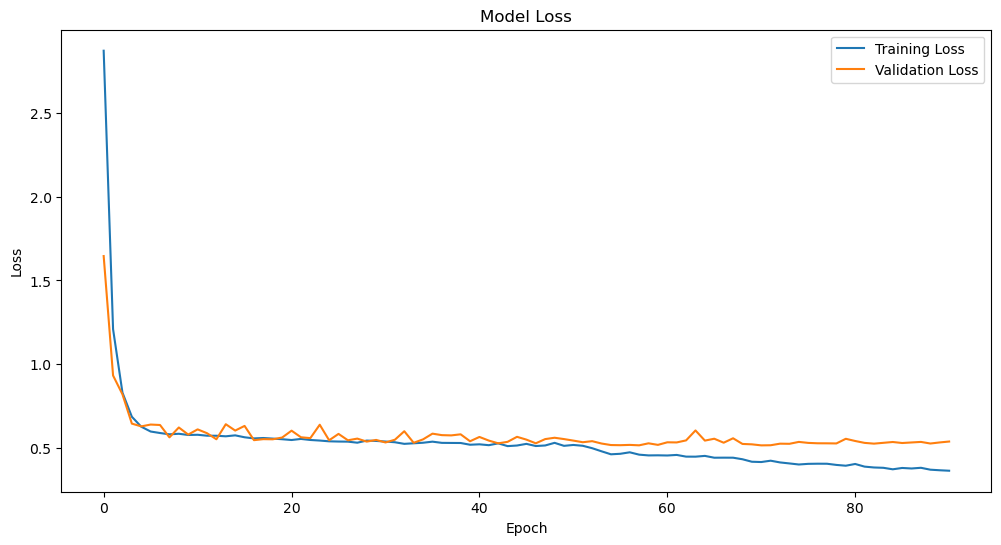

In [23]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(OUTPUT_DIR + 'Loss for model_merge')
plt.show()

1014

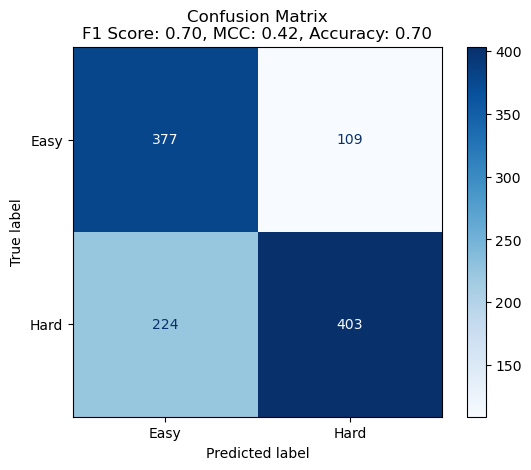

In [34]:
# Calculate the confusion matrix
cm = confusion_matrix(Y_test_dif, Y_pred)

f1 = f1_score(Y_test_dif,  Y_pred, average='weighted')
accuracy = accuracy_score(Y_test_dif,  Y_pred)
mcc = matthews_corrcoef(Y_test_dif,  Y_pred)

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix\nF1 Score: {f1:.2f}, MCC: {mcc:.2f}, Accuracy: {accuracy:.2f}")
plt.xticks([0,1],['Easy','Hard'])
plt.yticks([0,1],['Easy','Hard'])
plt.savefig(OUTPUT_DIR + 'Confusion Matrix for model_merge')

plt.show()


/tmp/ipykernel_103096/3371144874.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob_list[Y_test[i][0]][int(Y_prob[i]*10)%10] += 1


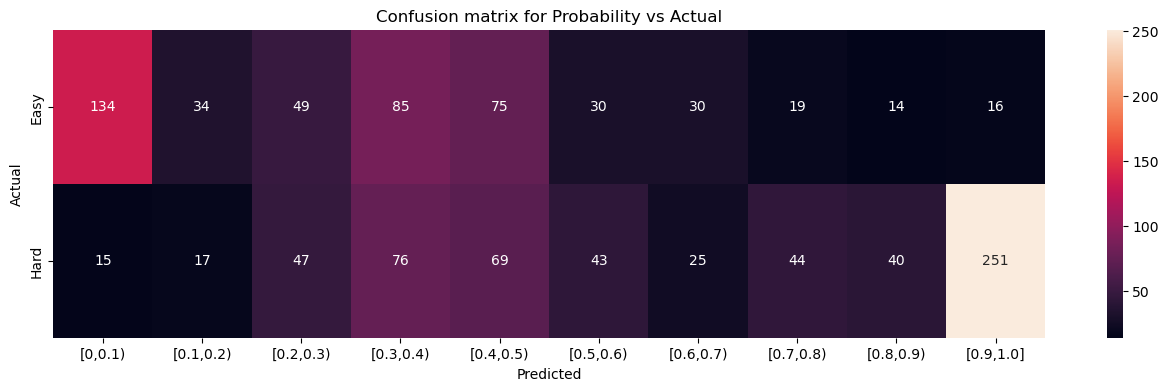

In [35]:
prob_list = np.zeros((2,10)) #first dimension is true_label, second dimension is probility.

#calculate the prob_list
for i in range(len(Y_prob)):
    #specical case
    if Y_prob[i] >= 1:
        prob_list[Y_test_dif[i][9] += 1
    else:
        prob_list[Y_test_dif[i]][int(Y_prob[i]*10)%10] += 1

plt.figure(figsize=(16,4))
sns.heatmap(prob_list, annot=True,  fmt='.0f', yticklabels=['Easy', 'Hard'], 
            xticklabels=['[0,0.1)', '[0.1,0.2)', '[0.2,0.3)', '[0.3,0.4)', '[0.4,0.5)', '[0.5,0.6)','[0.6,0.7)', '[0.7,0.8)', '[0.8,0.9)', '[0.9,1.0]'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion matrix for Probability vs Actual")
plt.savefig(OUTPUT_DIR+"/confusion_matrix_probability.png")
plt.show()

In [40]:
def permutation_importance(model, X_test_list, Y_test, accuracy_original, data_index, feature_index):
    accuracy_list = []
    for i in range(5):
        X_test_shuffled = X_test_list[data_index].copy()
        if data_index == 0 or data_index == 3 or data_index == 6:
            #if X_demo, shuffle 2nd dimension
            np.random.shuffle(X_test_shuffled[:, feature_index])
        else:
            #if not X_demo, shuffle 3nd dimension
            np.random.shuffle(X_test_shuffled[:,:, feature_index])
            
        X_test_list[data_index] = X_test_shuffled
        # Get predictions with shuffled feature
        Y_pred_shuffled = model.predict([X_test_list[0], X_test_list[1], X_test_list[2],X_test_list[3],X_test_list[4],X_test_list[5],X_test_list[6] ])
        Y_pred_shuffled = get_predict_label(Y_pred_shuffled,threshold = 0.5)
        accuracy_shuffled = accuracy_score(Y_test, Y_pred_shuffled)

        # Calculate accuracy drop
        accuracy_list.append(accuracy_original - accuracy_shuffled)
        
    return np.mean(accuracy_list)

In [41]:
subplot_title = ['Demongraphic','Baseline_eye','Baseline_ecg','Baseline_ecg_feature','Sample_eye','Sample_ecg','Sample_ecg_feature']
X_ticks = [0] * 7
X_ticks[0] = ['Original'] + ['Age', 'Gender', 'Race', 'Education', 'Smote_frequently',
       'Caffeine_Consumption', 'Q2_How long played games',
       'Q3_how often video games?',
       'Q4_how many hours playing video games?',
       'Q5_When you play video games how many hours',
       'Q6_How skilled',
       'Q7_your experience playing video games.',
       'Q8_First-person shooter',
       'Q9_Realistic military',
       'Q10_Driving or Racing',
       'Q11_Strategy',
       'Q12_Role-playing']
X_ticks[1] = ['Original'] + ['Pupil_left','Pupil_right','Gaze_X','Gaze_Y','missing_percentage']
X_ticks[2] = ['Original'] + ['Heart_rate', 'Heart_rate_mask', 'RR_interval', 'RR_interval_mask', 'Different in RR_interval', 'Different in RR_interval mask',]
X_ticks[3] = ['Original'] + ['Heart Rate mean', 'RR interval mean', 'RR interval SD', 'HRV', 'SD1', 'SD2', 'Ratio_sd1_sd2', 'Proportion_Next_R_peaks_greater_50_ms_', 'SNR', 'Very Low frequency power', 'Low frequency power', 'High frequency power', 'ratio_lf_hf']
X_ticks[4] = ['Original'] + ['Pupil_left','Pupil_right','Gaze_X','Gaze_Y']
X_ticks[5] = ['Original'] + ['Heart_rate', 'Heart_rate_mask', 'RR_interval', 'RR_interval_mask', 'Different in RR_interval', 'Different in RR_interval mask',]
X_ticks[6] = ['Original'] + ['Heart Rate mean', 'RR interval mean', 'RR interval SD', 'HRV', 'SD1', 'SD2', 'Ratio_sd1_sd2', 'Proportion_Next_R_peaks_greater_50_ms_', 'SNR', 'Very Low frequency power', 'Low frequency power', 'High frequency power', 'ratio_lf_hf']


In [42]:
Y_pred = model_merge.predict([X_test_demo, X_test_1_eye, X_test_1_ecg, X_test_1_ecg_feature,\
                         X_test_2_eye,X_test_2_ecg, X_test_2_ecg_feature])
Y_pred = get_predict_label(Y_pred,threshold = 0.5)
accuracy_original = accuracy_score(Y_test_dif, Y_pred)
accuracy_list = [0] * 7

for i in range(7):
    temp_list = []
    temp_list.append(accuracy_original)
    X_test_list = [X_test_demo, X_test_1_eye, X_test_1_ecg, X_test_1_ecg_feature,\
                         X_test_2_eye,X_test_2_ecg, X_test_2_ecg_feature].copy()

    #use 2nd dimension for X_demo and 3rd for other
    if i == 0 or i == 3 or i == 6:
        current_dimension = 1
    else:
        current_dimension = 2
    
    for j in range(X_test_list[i].shape[current_dimension]):
        print(i, '  ', j)
        mean_accuracy = permutation_importance(model_merge, X_test_list, Y_test_dif, accuracy_original, i, j)
        temp_list.append(mean_accuracy)
        
    accuracy_list[i] = temp_list

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
0    0
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
0    1
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
0    2
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
0    3
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
0    4
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35

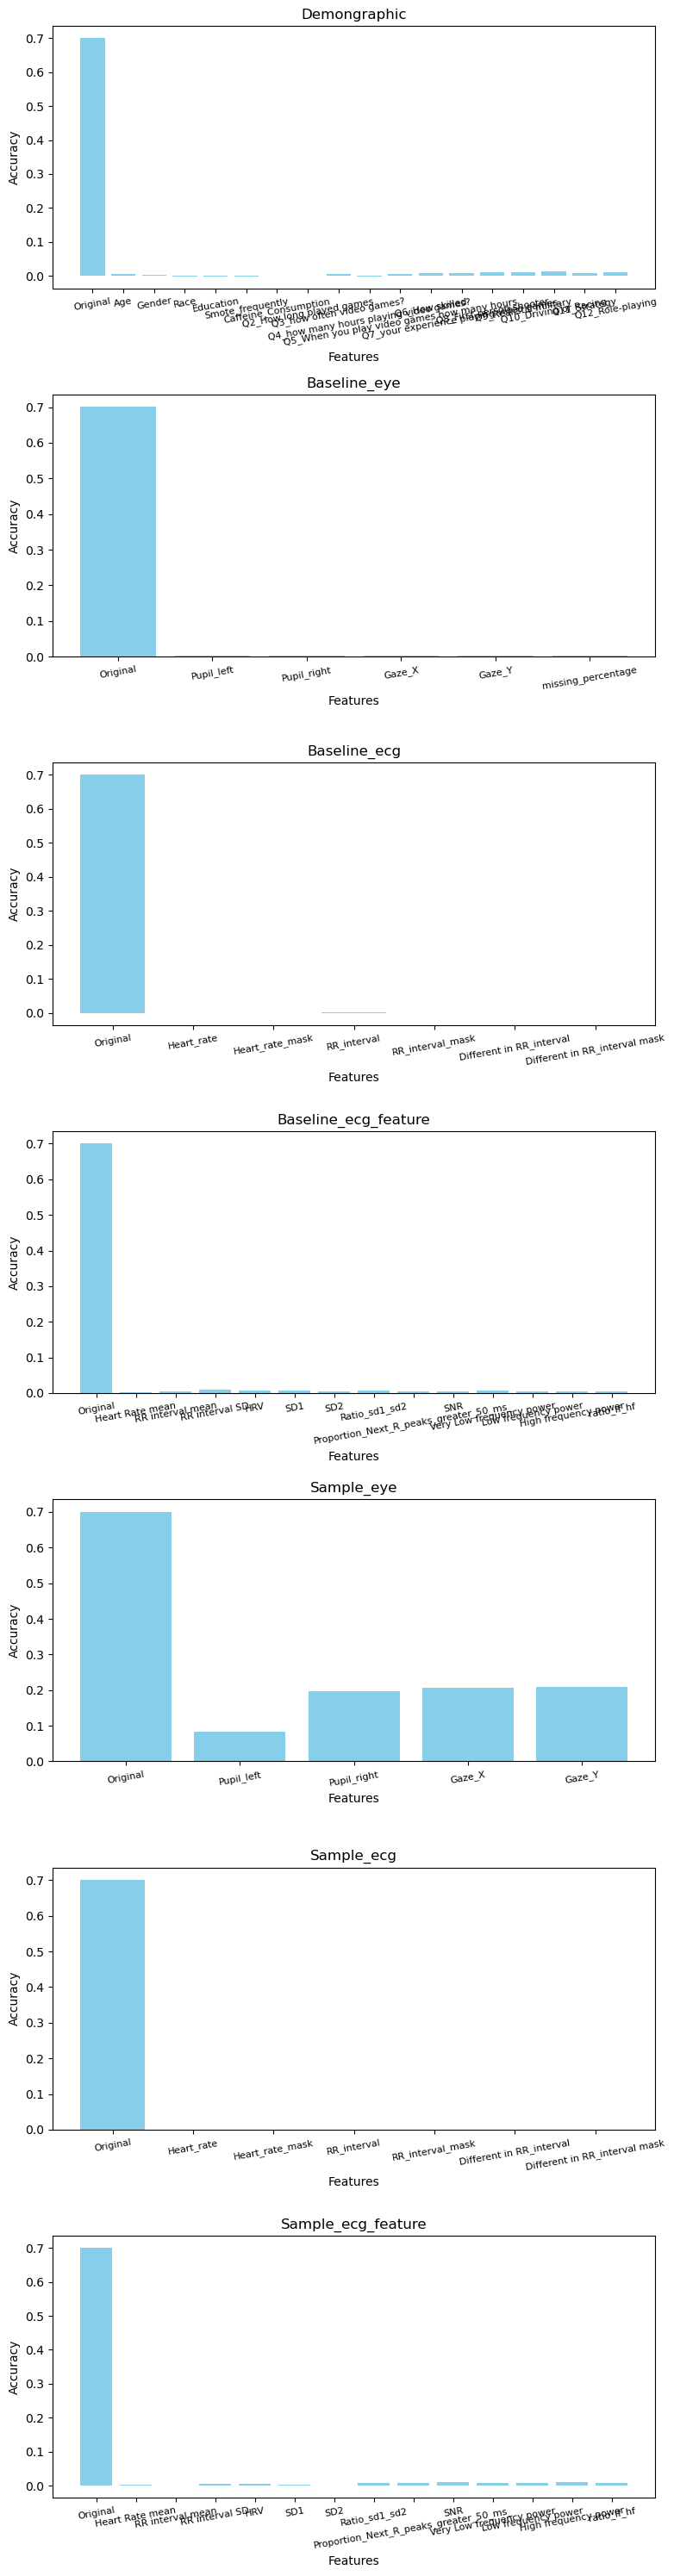

In [43]:
# Number of subplots (based on the first dimension)
n_subplots = len(accuracy_list)

# Create subplots
fig, axs = plt.subplots(n_subplots, 1, figsize=(8, 30))

# Plot each subplot
for i in range(n_subplots):
    axs[i].bar(range(len(accuracy_list[i])), accuracy_list[i], color='skyblue')
    axs[i].set_title(subplot_title[i])
    axs[i].set_xlabel('Features')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_xticks(range(len(X_ticks[i])))
    axs[i].set_xticklabels(X_ticks[i], rotation=10, fontsize=8)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'Feature Importance for Eye')
# Show the plot
plt.show()

# Transformer


In [15]:
EPOCHS = 200
BATCH_SIZE = 8
PATIENCE = 10

In [16]:
# Define the Transformer block with attention mask
def transformer_block(inputs, embed_dim, num_heads, ff_dim, dropout=0.2, mask=None):
    x = tf.keras.layers.MultiHeadAttention(key_dim=embed_dim, num_heads=num_heads, dropout=dropout)(inputs, inputs, inputs, attention_mask=mask)
    x = inputs + x
    res = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    x = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    x = tf.keras.layers.Dense(embed_dim)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = res + x
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x

In [17]:
# Define the model with attention mask
def build_model(input_shape, embed_dim, num_heads, ff_dim, dropout=0.2):
    inputs = tf.keras.layers.Input(shape=(input_shape[1], input_shape[2]), name='input_sample_eye')
    #mask   = tf.keras.layers.Input(shape=(input_shape[1], input_shape[2]), name='input_sample_eye_mask')  # Attention mask input

    sample_eye = tf.keras.layers.Dense(embed_dim)(inputs)
    sample_eye = transformer_block(sample_eye, embed_dim, num_heads, ff_dim, dropout)
    sample_eye = transformer_block(sample_eye, embed_dim, num_heads, ff_dim, dropout)
    sample_eye = transformer_block(sample_eye, embed_dim, num_heads, ff_dim, dropout)
    sample_eye = transformer_block(sample_eye, embed_dim, num_heads, ff_dim, dropout)
    sample_eye = transformer_block(sample_eye, embed_dim, num_heads, ff_dim, dropout)
    
    sample_eye = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(sample_eye)
    sample_eye = tf.keras.layers.Dense(128, activation="relu")(sample_eye)
    sample_eye = tf.keras.layers.Dropout(dropout)(sample_eye)
    sample_eye = tf.keras.layers.Dense(64, activation="relu")(sample_eye)
    sample_eye = tf.keras.layers.Dropout(dropout)(sample_eye)
    
    outputs    = tf.keras.layers.Dense(1, activation="sigmoid", name='difficulty')(sample_eye)

    
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
    
    return model
    




In [18]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

In [19]:
# Example usage
model = build_model(X_train_2_eye.shape, embed_dim=64, num_heads=4, ff_dim=256, dropout=0.2)
model.summary()

2024-09-18 22:32:59.743248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9566 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-09-18 22:32:59.743767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9566 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-18 22:32:59.744265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9566 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-09-18 22:32:59.744766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9566 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sample_eye    │ (None, 2500, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2500, 64)  │        320 │ input_sample_eye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2500, 64)  │     66,368 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0],      │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2500, 64)  │          0 │ dense[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2500, 256) │     16,640 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2500, 64)  │     16,448 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 2500, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2500, 64)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2500, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2500, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2500, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 2500, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2500, 256) │     16,640 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2500, 64)  │     16,448 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2500, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2500, 64)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 2500, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2500, 64)  │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 827,329 (3.16 MB)

 Trainable params: 827,329 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history =  model.fit([X_train_2_eye], [Y_train_dif], 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])

Epoch 1/200


I0000 00:00:1726713189.935816   71376 service.cc:145] XLA service 0x2ab0640018f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726713189.935854   71376 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726713189.935865   71376 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726713189.935868   71376 service.cc:153]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726713189.935871   71376 service.cc:153]   StreamExecutor device (3): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726713189.935873   71376 service.cc:153]   StreamExecutor device (4): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726713189.935875   71376 service.cc:153]   StreamExecutor device (5): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726713189.9358

467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5912 - loss: 0.6741

I0000 00:00:1726713341.919389   71873 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_179', 132 bytes spill stores, 132 bytes spill loads

I0000 00:00:1726713398.307782   71873 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_163', 132 bytes spill stores, 132 bytes spill loads

I0000 00:00:1726713407.887640   71873 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 8 bytes spill stores, 8 bytes spill loads



468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.5912 - loss: 0.6741

I0000 00:00:1726713437.714818   72353 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726713457.302875   72420 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38', 8 bytes spill stores, 8 bytes spill loads



468/468 ━━━━━━━━━━━━━━━━━━━━ 287s 502ms/step - accuracy: 0.5913 - loss: 0.6741 - val_accuracy: 0.6107 - val_loss: 0.6437 - learning_rate: 1.0000e-04
Epoch 2/200
468/468 ━━━━━━━━━━━━━━━━━━━━ 144s 213ms/step - accuracy: 0.6848 - loss: 0.6012 - val_accuracy: 0.6663 - val_loss: 0.5401 - learning_rate: 1.0000e-04
Epoch 3/200
468/468 ━━━━━━━━━━━━━━━━━━━━ 140s 210ms/step - accuracy: 0.7160 - loss: 0.5095 - val_accuracy: 0.6802 - val_loss: 0.5264 - learning_rate: 1.0000e-04
Epoch 4/200
468/468 ━━━━━━━━━━━━━━━━━━━━ 101s 215ms/step - accuracy: 0.7066 - loss: 0.5002 - val_accuracy: 0.6813 - val_loss: 0.5161 - learning_rate: 1.0000e-04
Epoch 5/200
468/468 ━━━━━━━━━━━━━━━━━━━━ 99s 211ms/step - accuracy: 0.7071 - loss: 0.4938 - val_accuracy: 0.6952 - val_loss: 0.5037 - learning_rate: 1.0000e-04
Epoch 6/200
468/468 ━━━━━━━━━━━━━━━━━━━━ 143s 214ms/step - accuracy: 0.7128 - loss: 0.4806 - val_accuracy: 0.6888 - val_loss: 0.5102 - learning_rate: 1.0000e-04
Epoch 7/200
468/468 ━━━━━━━━━━━━━━━━━━━━ 142s 2

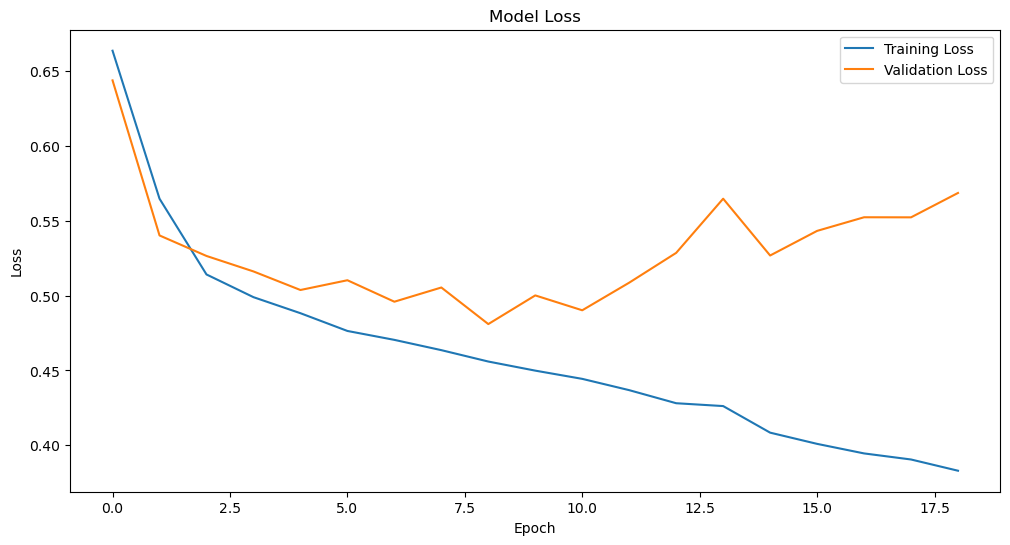

In [25]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(OUTPUT_DIR + 'Loss for model_merge')
plt.show()

In [23]:
def get_predict_label(predict_prob,threshold = 0.5):
    predict_label = []
    for y in predict_prob:
        if y <= threshold:
            predict_label.append(0)
        else:
            predict_label.append(1)
    
    return predict_label

In [27]:
# Y_pred = model_merge.predict([X_test_demo, X_test_1_eye, X_test_1_eye_wavelet, X_test_1_ecg, X_test_1_ecg_feature,\
#                          X_test_2_eye,X_test_2_ecg, X_test_2_ecg_feature])
Y_prob = model.predict([X_test_2_eye])


Y_pred = get_predict_label(Y_prob,threshold = 0.5)

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step

I0000 00:00:1726716897.479600   80343 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38', 8 bytes spill stores, 8 bytes spill loads



35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 571ms/step


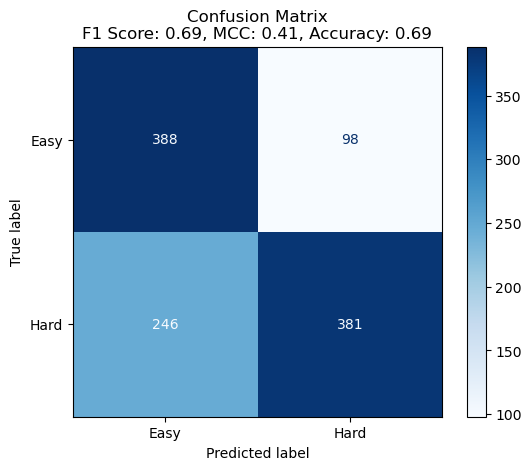

In [28]:
# Calculate the confusion matrix
cm = confusion_matrix(Y_test_dif, Y_pred)

f1 = f1_score(Y_test_dif,  Y_pred, average='weighted')
accuracy = accuracy_score(Y_test_dif,  Y_pred)
mcc = matthews_corrcoef(Y_test_dif,  Y_pred)

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix\nF1 Score: {f1:.2f}, MCC: {mcc:.2f}, Accuracy: {accuracy:.2f}")
plt.xticks([0,1],['Easy','Hard'])
plt.yticks([0,1],['Easy','Hard'])
plt.savefig(OUTPUT_DIR + 'Confusion Matrix for model_merge')

plt.show()


/tmp/ipykernel_70784/1143964149.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob_list[int(Y_test_dif[i])][int(Y_prob[i]*10)%10] += 1


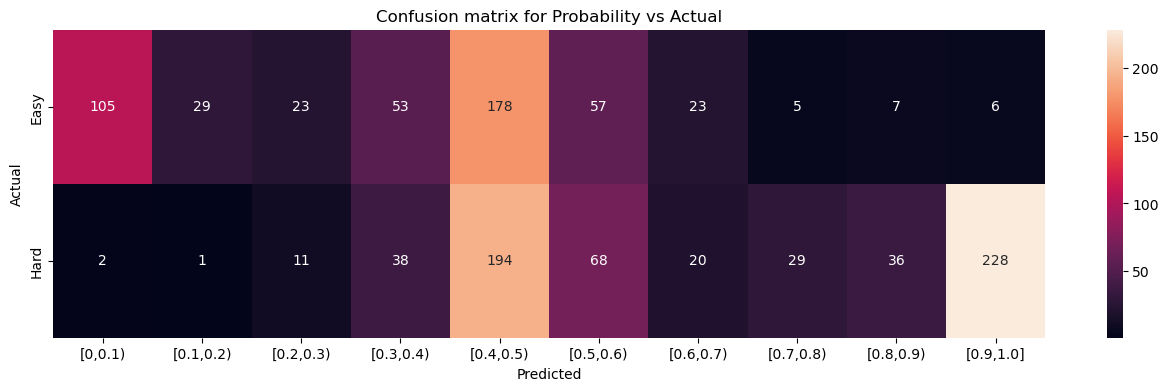

In [29]:
prob_list = np.zeros((2,10)) #first dimension is true_label, second dimension is probility.

#calculate the prob_list
for i in range(len(Y_prob)):
    #specical case
    if Y_prob[i] >= 1:
        prob_list[int(Y_test_dif[i])][9] += 1
    else:
        prob_list[int(Y_test_dif[i])][int(Y_prob[i]*10)%10] += 1

plt.figure(figsize=(16,4))
sns.heatmap(prob_list, annot=True,  fmt='.0f', yticklabels=['Easy','Hard'], 
            xticklabels=['[0,0.1)', '[0.1,0.2)', '[0.2,0.3)', '[0.3,0.4)', '[0.4,0.5)', '[0.5,0.6)','[0.6,0.7)', '[0.7,0.8)', '[0.8,0.9)', '[0.9,1.0]'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion matrix for Probability vs Actual")
plt.savefig(OUTPUT_DIR+"/confusion_matrix_probability.png")
plt.show()

In [15]:
print(f'demo:          {X_train_demo.shape}\n\
eye_1:         {X_train_1_eye.shape}\neye_1_wavelet: {X_train_1_eye_wavelet.shape}\n\
ecg_1:         {X_train_1_ecg.shape}\necg_1_feature: {X_train_1_ecg_feature.shape}\n\
eye_2:         {X_train_2_eye.shape}\n\
ecg_2:         {X_train_2_ecg.shape}\necg_2_feature: {X_train_2_ecg_feature.shape}\n')

demo:          (7162, 17)
eye_1:         (7162, 60000, 5)
eye_1_wavelet: (7162, 60000, 5)
ecg_1:         (7162, 480, 6)
ecg_1_feature: (7162, 13)
eye_2:         (7162, 2500, 4)
ecg_2:         (7162, 20, 6)
ecg_2_feature: (7162, 13)



In [16]:
def custom_CNN_layer(input_layer, start_neuron = 16, kernel_size=9, strides_size=1, max_pool_size=5, dropout=0.3, padding='valid'):
    cnn_layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    cnn_layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(cnn_layer)
    cnn_layer = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(cnn_layer)
    cnn_layer = tf.keras.layers.BatchNormalization()(cnn_layer)
    cnn_layer = tf.keras.layers.Dropout(dropout)(cnn_layer)
    return cnn_layer

In [17]:
#create model
def baseline_merge(shape, start_neuron = 16, kernel_size_1 = 5, kernel_size_2 = 3 , strides_size=1, max_pool_size_1 = 3, max_pool_size_2 = 2 , dropout=0.3, padding='valid'):    

    input_demo                 = tf.keras.Input((shape[1],), name='input_demo') 
    input_baseline_eye         = tf.keras.Input((shape[3], shape[4]), name='input_baseline_eye') 
    input_baseline_wavelet     = tf.keras.Input((shape[6], shape[7]), name='input_baseline_eye_wavelet') 
    input_baseline_ecg         = tf.keras.Input((shape[9], shape[10]), name='input_baseline_ecg')
    input_baseline_ecg_feature = tf.keras.Input((shape[12],), name='input_baseline_ecg_feature')
    
    input_sample_eye  = tf.keras.Input((shape[14], shape[15]), name='input_sample_eye') 
    input_sample_ecg = tf.keras.Input((shape[17], shape[18]), name='input_sample_ecg')
    input_sample_ecg_feature = tf.keras.Input((shape[20],), name='input_sample_ecg_feature')


    
    #baseline eye
    baseline_eye = custom_CNN_layer(input_baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)

    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_eye)
    baseline_eye = tf.keras.layers.Dropout(dropout)(baseline_eye)
    baseline_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_eye)
    baseline_eye = tf.keras.layers.Dropout(dropout)(baseline_eye)
    baseline_eye = tf.keras.layers.Flatten()(baseline_eye)
    #baseline_eye = tf.keras.layers.Dense(start_neuron * 4)(baseline_eye)

    # #baseline eye_wavelet
    # baseline_eye_wavelet = custom_CNN_layer(input_baseline_wavelet, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)

    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = custom_CNN_layer(baseline_eye_wavelet, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_eye_wavelet = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_eye_wavelet)
    # baseline_eye_wavelet = tf.keras.layers.Dropout(dropout)(baseline_eye_wavelet)
    # baseline_eye_wavelet = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_eye_wavelet)
    # baseline_eye_wavelet = tf.keras.layers.Dropout(dropout)(baseline_eye_wavelet)
    # baseline_eye_wavelet = tf.keras.layers.Flatten()(baseline_eye_wavelet)
   # baseline_eye_wavelet = tf.keras.layers.Dense(start_neuron * 4)(baseline_eye_wavelet)
    
    # Baseline
    baseline_ecg = custom_CNN_layer(input_baseline_ecg, start_neuron, kernel_size=kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron , kernel_size=kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron , kernel_size=kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron * 2, kernel_size=kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron * 2, kernel_size=kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(baseline_ecg)
    baseline_ecg = tf.keras.layers.Dropout(dropout)(baseline_ecg)
    baseline_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(baseline_ecg)
    baseline_ecg = tf.keras.layers.Dropout(dropout)(baseline_ecg)
    baseline_ecg = tf.keras.layers.Flatten()(baseline_ecg)
    #baseline_ecg = tf.keras.layers.Dense(start_neuron * 4)(baseline_ecg)
  
    
    #samples_eye
    sample_eye  = custom_CNN_layer(input_sample_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron , kernel_size =  kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron , kernel_size =  kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron * 4, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron * 4, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_eye)
    sample_eye = tf.keras.layers.Dropout(dropout)(sample_eye)
    sample_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_eye)
    sample_eye = tf.keras.layers.Dropout(dropout)(sample_eye)
    sample_eye = tf.keras.layers.Flatten()(sample_eye)
   # sample_eye = tf.keras.layers.Dense(start_neuron * 8)(sample_eye)
    

    # Samples_ecg
    sample_ecg = custom_CNN_layer(input_sample_ecg, start_neuron, kernel_size=kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_ecg = custom_CNN_layer(sample_ecg, start_neuron * 2, kernel_size=kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    #sample_ecg = custom_CNN_layer(sample_ecg, start_neuron * 2, kernel_size=kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_ecg)
    sample_ecg = tf.keras.layers.Dropout(dropout)(sample_ecg)
    sample_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_ecg)
    sample_ecg = tf.keras.layers.Dropout(dropout)(sample_ecg)
    sample_ecg = tf.keras.layers.Flatten()(sample_ecg)
    #sample_ecg = tf.keras.layers.Dense(start_neuron * 4)(sample_ecg)


    
    concat_layer = tf.keras.layers.Concatenate()([baseline_eye, baseline_ecg, sample_eye,sample_ecg, input_demo, input_baseline_ecg_feature, input_sample_ecg_feature])
    output_layer = tf.keras.layers.Dense(start_neuron*4,activation=tf.keras.layers.LeakyReLU())(concat_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    output_layer = tf.keras.layers.Dense(start_neuron*8,activation=tf.keras.layers.LeakyReLU())(output_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    output_0 = tf.keras.layers.Dense(1, activation='linear', name='accuracy')(output_layer)

    #baseline_eye_wavelet, 
    
    model = tf.keras.Model(inputs=[input_demo, input_baseline_eye, input_baseline_ecg, input_baseline_ecg_feature,\
                                   input_sample_eye, input_sample_ecg, input_sample_ecg_feature], outputs=[output_0])
    
    model.compile(optimizer='adam', loss='mae')
    return model

In [18]:
current_shape = X_train_demo.shape + X_train_1_eye.shape + X_train_1_eye_wavelet.shape + X_train_1_ecg.shape + X_train_1_ecg_feature.shape \
+ X_train_2_eye.shape + X_train_2_ecg.shape + X_train_2_ecg_feature.shape

current_shape

(7162,
 17,
 7162,
 60000,
 5,
 7162,
 60000,
 5,
 7162,
 480,
 6,
 7162,
 13,
 7162,
 2500,
 4,
 7162,
 20,
 6,
 7162,
 13)

In [19]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

In [20]:
#model_merge = baseline_merge(current_shape, start_neuron=16)
model_merge = baseline_merge(current_shape, start_neuron=16, kernel_size_1 = 5, kernel_size_2 = 3 , strides_size= 1, max_pool_size_1 = 3, max_pool_size_2 = 2 , dropout=0.2, padding='same')
model_merge.summary()

# history = model_merge.fit([X_train_demo, X_train_1_eye, X_train_1_eye_wavelet, X_train_1_ecg, X_train_1_ecg_feature,\
#                          X_train_2_eye,X_train_2_ecg, X_train_2_ecg_feature], [Y_train_dif], 
#                     epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])

history = model_merge.fit([X_train_demo, X_train_1_eye, X_train_1_ecg, X_train_1_ecg_feature,\
                         X_train_2_eye,X_train_2_ecg, X_train_2_ecg_feature], [Y_train_acc], 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])

2024-09-16 21:17:31.445803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9566 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-09-16 21:17:31.446317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9566 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-16 21:17:31.446808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9566 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-09-16 21:17:31.447278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9566 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_baseline_eye  │ (None, 60000, 5)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60000, 16) │        416 │ input_baseline_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 60000, 16) │      1,296 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 20000, 16) │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20000, 16) │         64 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20000, 16) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 20000, 16) │      1,296 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 20000, 16) │      1,296 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 6667, 16)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6667, 16)  │         64 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 6667, 16)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 6667, 16)  │      1,296 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 6667, 16)  │      1,296 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 2223, 16)  │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2223, 16)  │         64 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2223, 16)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_sample_eye    │ (None, 2500, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 2223, 16)  │      1,296 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 2500, 16)  │        336 │ input_sample_eye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 2223, 16)  │      1,296 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 2500, 16)  │      1,296 │ conv1d_28[0][0] 

 Total params: 264,156 (1.01 MB)

 Trainable params: 263,004 (1.00 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/200


2024-09-16 21:18:17.052985: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


359/359 ━━━━━━━━━━━━━━━━━━━━ 79s 84ms/step - loss: 7.3497 - val_loss: 1.9587 - learning_rate: 0.0010
Epoch 2/200
359/359 ━━━━━━━━━━━━━━━━━━━━ 52s 68ms/step - loss: 1.3605 - val_loss: 0.5988 - learning_rate: 0.0010
Epoch 3/200
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - loss: 0.4586 - val_loss: 0.3710 - learning_rate: 0.0010
Epoch 4/200
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - loss: 0.2509 - val_loss: 0.2613 - learning_rate: 0.0010
Epoch 5/200
359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - loss: 0.2064 - val_loss: 0.2625 - learning_rate: 0.0010
Epoch 6/200
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - loss: 0.1928 - val_loss: 0.2541 - learning_rate: 0.0010
Epoch 7/200
359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - loss: 0.1924 - val_loss: 0.2492 - learning_rate: 0.0010
Epoch 8/200
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - loss: 0.1943 - val_loss: 0.2550 - learning_rate: 0.0010
Epoch 9/200
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - loss: 0.1939 - val_loss: 0.2702 - learning_rate: 0.

In [21]:
Y_pred = model_merge.predict([X_test_demo, X_test_1_eye, X_test_1_ecg, X_test_1_ecg_feature,\
                         X_test_2_eye,X_test_2_ecg, X_test_2_ecg_feature])
Y_pred

54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step


array([[0.5494488 ],
       [0.69093764],
       [0.57513183],
       ...,
       [1.0375538 ],
       [0.95159405],
       [0.9071366 ]], dtype=float32)

(0.0, 1.1)

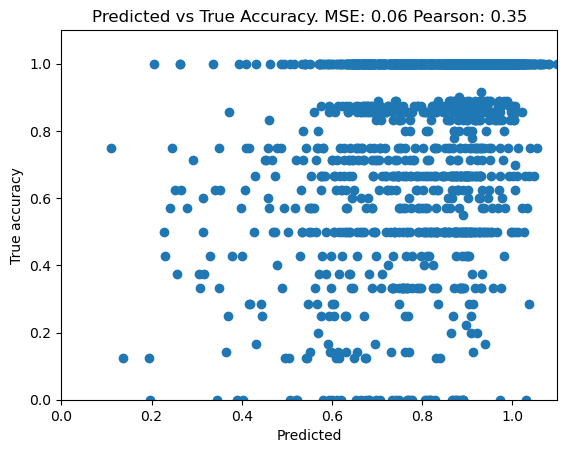

In [33]:
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import pearsonr 
plt.scatter(Y_pred,Y_test_acc)
plt.title("Predicted vs True Accuracy. MSE: " + str(round(mse(Y_pred,Y_test_acc),2)) + " Pearson: " + str(round(pearsonr(Y_pred.reshape(-1),Y_test_acc)[0],2)))
plt.xlabel("Predicted")
plt.ylabel("True accuracy")
plt.xlim(0,1.1)
plt.ylim(0,1.1)

0.3517910859622336

# Grid seach

In [ ]:
# dict_seach = {
#     'start_neuron'    : [16],
#     'kernel_size_1'   : [3,5,7],
#     'kernel_size_2'   : [3,5,7],
#     'strides_size'    : [1,2,3],
#     'max_pool_size_1' : [2,3,5],
#     'max_pool_size_2' : [2,3,5],
#     'dropout'         : [0.2,0.3,0.4],
#     'padding'         : ['same','valid']
# }



In [ ]:
# i = 0
# for start_neuron in dict_seach['start_neuron']:
#     for kernel_size_1 in dict_seach['kernel_size_1']:
#         for kernel_size_2 in dict_seach['kernel_size_2']:
#             for strides_size in dict_seach['strides_size']:
#                 for max_pool_size_1 in dict_seach['max_pool_size_1']:
#                     for max_pool_size_2 in dict_seach['max_pool_size_2']:
#                         for dropout in dict_seach['dropout']:
#                             for padding in dict_seach['padding']:
#                                 title = f'{i}_{start_neuron}_{kernel_size_1}_{kernel_size_2}_{strides_size}_{max_pool_size_1}_{max_pool_size_2}_{dropout}_{padding}'
#                                 print(title)

#                                 reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
#                                 early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

#                                 try:
#                                     model_merge = baseline_merge(current_shape, start_neuron=start_neuron, kernel_size_1 = kernel_size_1, kernel_size_2 = kernel_size_2 , strides_size= strides_size, max_pool_size_1 = max_pool_size_1, max_pool_size_2 = max_pool_size_2 , dropout=dropout, padding=padding)
#                                     #model_merge.summary()
                                    
#                                     history = model_merge.fit([X_train_demo, X_train_1_eye, X_train_1_eye_wavelet, X_train_1_ecg, X_train_1_ecg_feature,\
#                                                              X_train_2_eye,X_train_2_ecg, X_train_2_ecg_feature], [Y_train_dif], 
#                                                         epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=0, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])
#                                 except:
#                                     print('Error, continue')
#                                     i += 1
#                                     continue

#                                 Y_pred = model_merge.predict([X_test_demo, X_test_1_eye, X_test_1_eye_wavelet, X_test_1_ecg, X_test_1_ecg_feature,\
#                                                          X_test_2_eye,X_test_2_ecg, X_test_2_ecg_feature])
                                
#                                 # Calculate the confusion matrix
#                                 cm = confusion_matrix(Y_test_dif, np.argmax(Y_pred,axis=1))
#                                 f1 = f1_score(Y_test_dif,  np.argmax(Y_pred,axis=1), average='weighted')
#                                 accuracy = accuracy_score(Y_test_dif,  np.argmax(Y_pred,axis=1))
#                                 mcc = matthews_corrcoef(Y_test_dif,  np.argmax(Y_pred,axis=1))
#                                 # Display the confusion matrix using Matplotlib
#                                 disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#                                 disp.plot(cmap=plt.cm.Blues)
#                                 plt.title(f"Confusion Matrix for {title}\nF1 Score: {f1:.2f}, MCC: {mcc:.2f}, Accuracy: {accuracy:.2f}")
                                
#                                 plt.savefig(OUTPUT_DIR + 'Confusion_Matrix_' + title + '.png')
#                                 plt.close()
                                
#                                 i += 1